In [1]:
import matplotlib.pyplot as plt
import vtk
import numpy as np
import sys
import math
import os
import glob
from vtk.util.numpy_support import *
import pandas
from multiprocessing import Pool
from scipy.stats import kurtosis, skew

In [2]:
def read_vti(filename):
    reader = vtk.vtkXMLImageDataReader()
    reader.SetFileName(filename)
    reader.Update()
    return reader.GetOutput()

def write_vti(filename,data):
    writer = vtk.vtkXMLImageDataWriter()
    writer.SetInputData(data)
    writer.SetFileName(filename)
    writer.Update()

def compute_3d_to_1d_map(x,y,z,dimx,dimy,dimz):
    return x + dimx*(y+dimy*z)

def get_cumulative_hist(data, nbins):
    hist = np.histogram(data,nbins)[0]
    totPts = sum(hist)
    ## compute cumulative distribution
    hist = hist/float(totPts)
    cum_dist = np.cumsum(hist)
    return cum_dist

def get_emd(dist1,dist2):
    emd = 0
    for i in range(len(dist1)):
        emd = emd + np.absolute(dist1[i]-dist2[i])
    return emd

def compare_moments(block_signature,feature):
    diff = 0
    weights = [0.25,0.25,0.25,0.25]
    for i in range(len(feature)):
        val = np.absolute(feature[i] - block_signature[i])
        #val = np.power(val,2.0)
        diff = diff + val*weights[i]
    return diff

def get_jsdiv(dist1,dist2):
    kldiv1=0
    kldiv2=0
    jsdiv=0
    nbins = len(dist1)
    for i in range(nbins):
        if dist1[i] > 0.0 and dist2[i] > 0.0:
            kldiv1 = kldiv1 + dist1[i]*np.log(dist1[i]/dist2[i])
            
    for i in range(nbins):
        if dist1[i] > 0.0 and dist2[i] > 0.0:
            kldiv2 = kldiv2 + dist2[i]*np.log(dist2[i]/dist1[i])
            
    jsdiv = 0.5*(kldiv1+kldiv2)        
            
    return jsdiv

In [3]:
## MFIX data files
nbins = 64
mixing_ratio = 0.4
varname1 = 'ClusterIds'
varname2 = 'ImageScalars'
cluster_data =  read_vti('/disk2/Source_Codes/SLIC_3D/build/cluster.vti')
raw_data = read_vti('/disk1/MFIX_bubble_fields/original_timestep_75.vti')
feature_dist_input = '../feature_dists/mfix_bubble_datavals_2.csv'
outfile = '../out/mfix_case_3/slic_compare.vti'
range_vals = cluster_data.GetPointData().GetArray(varname1).GetRange()
num_clusters = int(range_vals[1]) + 1

In [4]:
# ## Pele data files
# nbins = 128
# mixing_ratio = 0.3
# varname1 = 'ClusterIds'
# varname2 = 'magvort'
# cluster_data =  read_vti('/disk2/Source_Codes/SLIC_3D/build/cluster.vti')
# raw_data = read_vti('/disk1/PeleData/Pele_resampled_vti/pele_resampled_0.vti')
# feature_dist_input = '../feature_dists/pele.csv'
# outfile = '../out/pele/slic_compare.vti'
# range_vals = cluster_data.GetPointData().GetArray(varname1).GetRange()
# num_clusters = int(range_vals[1]) + 1

In [5]:
# ## Vortex data files
# nbins = 64
# mixing_ratio = 0.3
# varname1 = 'ClusterIds'
# varname2 = 'ImageScalars'
# cluster_data =  read_vti('/disk2/Source_Codes/SLIC_3D/build/cluster.vti')
# raw_data = read_vti('/disk1/vortex_vti/vortex_10.vti')
# feature_dist_input = '../feature_dists/vortex_1.csv'
# outfile = '../out/vortex/slic_compare.vti'
# range_vals = cluster_data.GetPointData().GetArray(varname1).GetRange()
# num_clusters = int(range_vals[1]) + 1

mean is: 0.0015747282186948854
var is: 0.0005384881645194858
skew is: 18.0368503177
kurtosis is: 349.557917694


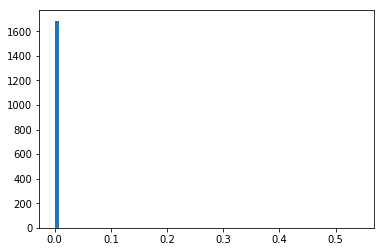

In [6]:
## load feature distribution
df = pandas.read_csv(feature_dist_input)
feature_data = np.asarray(df[varname2])
feature_dist = np.histogram(feature_data,nbins)[0]
feature_dist_edges = np.histogram(feature_data,nbins)[1]

feature_points = sum(feature_dist)
feature_dist = feature_dist/float(feature_points)

## compute cumulative distribution
cum_feature_dist = np.cumsum(feature_dist)

plt.hist(feature_data,nbins)
#plt.plot(cum_feature_dist)

### compute moments
m1 = np.average(feature_data)
m2 = np.var(feature_data)
m3 = skew(feature_data)
m4 = kurtosis(feature_data)

# print 'mean is: ' + str(m1)
# print 'var is: ' + str(m2)
# print 'skew is: ' + str(m3)
# print 'kurtosis is: ' + str(m4)

feature_moments = [m1,m2,m3,m4]

In [7]:
#### This processes one time step

## declare 2D list
cluster_based_data=[[] for i in xrange(num_clusters)]

np_cluster_array = vtk.util.numpy_support.vtk_to_numpy(cluster_data.GetPointData().GetArray(varname1))
np_data_array = vtk.util.numpy_support.vtk_to_numpy(raw_data.GetPointData().GetArray(varname2))

for i in range(len(np_cluster_array)):
    cluster_based_data[np_cluster_array[i]].append(np_data_array[i])

cluster_kldiv = []
cluster_moments_comp = []
mixed_vals = []
cluster_emd = []

for i in range(num_clusters):
    
    cluster_hist = get_cumulative_hist(cluster_based_data[i], nbins)
    emd = get_emd(cluster_hist,cum_feature_dist)
    cluster_emd.append(emd)
    
    m1 = (np.average(cluster_based_data[i]))
    m2 = (np.var(cluster_based_data[i]))
    m3 = (skew(cluster_based_data[i]))
    m4 = (kurtosis(cluster_based_data[i]))
    cluster_moments = [m1,m2,m3,m4]
    cluster_moments_comp.append(compare_moments(cluster_moments,feature_moments))
    
    cluster_histogram = np.histogram(cluster_based_data[i], nbins)[0]
    norm_cluster_histogram = cluster_histogram/float(len(cluster_based_data[i]))
    kldiv = get_jsdiv(norm_cluster_histogram,feature_dist)
    cluster_kldiv.append(kldiv)

## Normalize the metric values    
cluster_kldiv = (cluster_kldiv-np.min(cluster_kldiv))/(np.max(cluster_kldiv)-np.min(cluster_kldiv))
cluster_moments_comp = (cluster_moments_comp-np.min(cluster_moments_comp))/(np.max(cluster_moments_comp)-np.min(cluster_moments_comp))
cluster_emd = (cluster_emd-np.min(cluster_emd))/(np.max(cluster_emd)-np.min(cluster_emd))

## flip the values, now higher values are important to us    
cluster_kldiv = 1.0 - cluster_kldiv    
cluster_moments_comp = 1.0 - cluster_moments_comp
cluster_emd = 1.0 - cluster_emd

## Do linear mixing of the two metric values
for i in range(num_clusters):
    val = cluster_kldiv[i]*mixing_ratio + (1-mixing_ratio)*cluster_moments_comp[i]
    mixed_vals.append(val)
    
emd_arr = vtk.vtkDoubleArray()
emd_arr.SetName('emd_val')
moments_arr = vtk.vtkDoubleArray()
moments_arr.SetName('moment_val')
kldiv_arr = vtk.vtkDoubleArray()
kldiv_arr.SetName('jsdiv_val')
mixed_arr = vtk.vtkDoubleArray()
mixed_arr.SetName('mixed_val')

clusterIdsArr = cluster_data.GetPointData().GetArray(varname1)

for i in range(len(np_cluster_array)):
    cid =  clusterIdsArr.GetTuple1(i)
    emd_arr.InsertNextTuple1(cluster_emd[int(cid)])
    moments_arr.InsertNextTuple1(cluster_moments_comp[int(cid)])
    kldiv_arr.InsertNextTuple1(cluster_kldiv[int(cid)])
    mixed_arr.InsertNextTuple1(mixed_vals[int(cid)])
    
raw_data.GetPointData().AddArray(emd_arr) 
raw_data.GetPointData().AddArray(moments_arr) 
raw_data.GetPointData().AddArray(kldiv_arr)
raw_data.GetPointData().AddArray(mixed_arr)
write_vti(outfile,raw_data)